In [1]:
from util import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

from scipy import stats
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from joblib import dump, load

In [2]:
data_log, data_dash = get_data_frames()
result_total, labels = get_data_concated(data_log, data_dash)

In [3]:
def get_data_concated(data_log, data_dash):
  #removing all columns with std equal to 0.0, because they are constant 
  #variables and did not help in creating the model
  for colum in data_log.columns:
      if(data_log[colum].std()==0.0):
          data_log = data_log.drop(columns=[colum])
      
  #merging dataframes to correlate QoS results with telemetry
  data_log = data_log.groupby("timestamp").mean().reset_index()
  result_total = pd.concat(
      [data_log.set_index("timestamp"), data_dash.set_index("timestamp")],
      axis=1,
      join="outer",
  )

  #fill in the empty space with the column measurement
  for index in result_total.columns:
    media = result_total[index].mean()
    result_total[index] = result_total[index].fillna(media)
  result_total = result_total.reset_index()

  #drop the outliers
  z_scores = np.abs(stats.zscore(result_total['framesDisplayedCalc']))
  threshold = 3
  result_total = result_total[(z_scores < threshold)]

  #get the labels
  labels = result_total['framesDisplayedCalc']

  #and drop the rest
  columns_to_remove = list(data_dash.columns)
  columns_to_remove.remove('timestamp')
  result_total = result_total.drop(columns=columns_to_remove)
  return result_total


### Random Florest Model

In [4]:
def train_rf_model(features_train: pd.DataFrame, labels_train: pd.Series):
    X_train, X_validation, y_train, y_validation = train_test_split(
        features_train,
        np.ravel(labels_train),
        test_size=0.20,
        random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=80,
        min_samples_split=5,
        min_samples_leaf=2,
        bootstrap=True,
        verbose=1,
        max_features='sqrt',
        n_jobs=2,
        random_state=42
    )

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = cross_val_score(
        rf_model,
        X_train_scaled,
        y_train,
        cv=kf,
        scoring=mae_scorer
    )

    avg_cv_score = np.mean(cv_scores)

    rf_model.fit(X_train_scaled, y_train)

    y_pred_rf = rf_model.predict(X_validation_scaled)
    mae_rf = mean_absolute_error(y_validation, y_pred_rf)
    nmae_rf = mae_rf / np.mean(y_validation)

    feature_importances = rf_model.feature_importances_
    print(feature_importances)

    return mae_rf, nmae_rf, rf_model, feature_importances

### GridSearch RandomFlorest

In [9]:
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    nmae_value = mae / np.mean(y_true)
    return nmae_value
def train_rf_model_gridsearch(features_train: pd.DataFrame, labels_train: pd.Series):
    X_train, X_validation, y_train, y_validation = train_test_split(
        features_train,
        np.ravel(labels_train),
        test_size=0.20,
        random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    rf_model = RandomForestRegressor(random_state=42, n_jobs=2)

    nmae_scorer = make_scorer(nmae, greater_is_better=False)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]

    random_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
    }

    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=random_grid,
        scoring=nmae_scorer,
        cv=kf,
        verbose=3,  
        n_jobs=2
    )

    grid_search.fit(X_train_scaled, y_train)

    best_rf_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Melhores hiperparâmetros: {best_params}")

    y_pred_rf = best_rf_model.predict(X_validation_scaled)
    mae_rf = mean_absolute_error(y_validation, y_pred_rf)
    nmae_rf = nmae(y_validation, y_pred_rf)

    feature_importances = best_rf_model.feature_importances_
    print(f"Importâncias das features: {feature_importances}")

    return mae_rf, nmae_rf, best_rf_model, feature_importances


### XGBoostRegressor Model

In [20]:
def train_xgb_model(data, answer):
    X_train, X_validation, y_train, y_validation = train_test_split(
        data,
        np.ravel(answer),
        test_size=0.20,
        random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    xgb_model = XGBRegressor(
        n_estimators=800,
        learning_rate=0.01,  
        max_depth=50, 
        n_jobs=2,
        random_state=42
    )

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = cross_val_score(
        xgb_model,
        X_train_scaled,
        y_train,
        cv=kf,
        scoring=mae_scorer
    )
    avg_cv_score = np.mean(cv_scores)

    xgb_model.fit(
        X_train_scaled,
        y_train,
        eval_set=[(X_validation_scaled, y_validation)],
        verbose=False
    )

    y_pred = xgb_model.predict(X_validation_scaled)
    mae = mean_absolute_error(y_validation, y_pred)
    nmae = mae / np.mean(y_validation)

    feature_importances = xgb_model.feature_importances_
   
    print(feature_importances)

    return mae, nmae, xgb_model, feature_importances

### Testes

In [8]:
mae, nmae, model, pred = train_rf_model(result_total.copy(deep=True), labels)
print(f"{nmae*100:.4f}%")
alert_end()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_job

[0.09209287 0.09116703 0.0646429  0.000775   0.03754771 0.00080887
 0.10076091 0.0974084  0.06676483 0.02996064 0.03577648 0.02613584
 0.09441898 0.09979652 0.06428768 0.0307485  0.03697623 0.02993059]
28.2363%


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    6.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/kilmer/Development/data-science/search-telemetry-service-estimation/.env/lib/python3.12/site-packages/plyer/platforms/linux/notification.py:103: UserWarning: The Python dbus package is not installed.
Try installing it with your distribution's package manager, it is usually called python-dbus or python3-dbus, but you might have to try dbus-python instead, e.g. when using pip.
  warnings.warn(msg)


In [21]:
mae, nmae, model, pred = train_xgb_model(result_total.copy(deep=True), labels)
print(f"{nmae*100:.4f}%")
alert_end()

[0.01877095 0.37679797 0.         0.03202378 0.01856376 0.01534593
 0.075899   0.         0.         0.13123943 0.01881297 0.01930676
 0.02122366 0.         0.         0.19684556 0.0220938  0.02861704
 0.02445937]
32.1057%


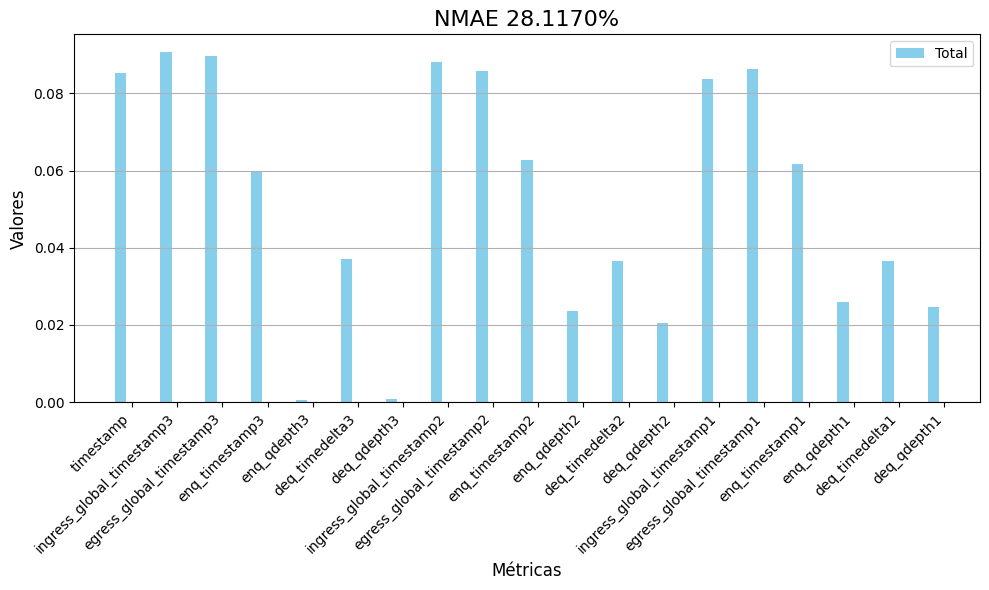

In [38]:
total = pred
labels = result_total.columns

x = np.arange(len(labels))

width = 0.25
plt.figure(figsize=(10, 6))
plt.bar(x - width, total, width, label='Total', color='skyblue')

plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.title(f'NMAE {nmae*100:.4f}%', fontsize=16)
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [10]:
mae, nmae, model, pred = train_rf_model_gridsearch(result_total, labels)
print(f"{nmae*100:.4f}%")

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits
[CV 1/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=True, max_de

/home/kilmer/Development/data-science/search-telemetry-service-estimation/.env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130;, score=-0.294 total time=   5.1s
[CV 1/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=140;, score=-0.293 total time=   5.7s
[CV 1/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120;, score=-0.292 total time=   4.9s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120;, score=-0.296 total time=   4.7s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=140;, score=-0.297 total time=   5.4s
[CV 3/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120;, score=-0.293 total time=   4.8s
[CV 2/3] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_le

KeyboardInterrupt: 

In [6]:
result_total = result_total.drop(columns=['timestamp'])

In [7]:
result_total

,ingress_global_timestamp3,egress_global_timestamp3,enq_timestamp3,enq_qdepth3,deq_timedelta3,deq_qdepth3,ingress_global_timestamp2,egress_global_timestamp2,enq_timestamp2,enq_qdepth2,deq_timedelta2,deq_qdepth2,ingress_global_timestamp1,egress_global_timestamp1,enq_timestamp1,enq_qdepth1,deq_timedelta1,deq_qdepth1
0,3.909507e+10,3.909507e+10,4.403598e+08,0.00000,34.000000,0.000000,3.916932e+10,3.916932e+10,5.146125e+08,0.000000,34.000000,0.000000,3.924525e+10,3.924525e+10,5.905407e+08,0.000000,32.400000,0.000000
1,3.909580e+10,3.909580e+10,4.410972e+08,0.00000,26.333333,0.000000,3.917006e+10,3.917006e+10,5.153497e+08,0.000000,36.500000,0.000000,3.924598e+10,3.924598e+10,5.912778e+08,0.000000,30.333333,0.000000
2,3.909691e+10,3.909691e+10,4.422026e+08,0.00000,27.166667,0.000000,3.917116e+10,3.917116e+10,5.164553e+08,0.000000,26.000000,0.000000,3.924709e+10,3.924709e+10,5.923834e+08,0.000000,31.166667,0.000000
3,3.909790e+10,3.909790e+10,4.431917e+08,0.00000,28.142857,0.000000,3.917215e+10,3.917215e+10,5.174444e+08,0.000000,31.428571,0.000000,3.924808e+10,3.924808e+10,5.933725e+08,0.000000,28.285714,0.000000
4,3.909885e+10,3.909885e+10,4.441475e+08,0.00000,41.888889,0.000000,3.917311e+10,3.917311e+10,5.184002e+08,0.000000,31.777778,0.000000,3.924903e+10,3.924903e+10,5.943283e+08,0.000000,32.666667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32247,5.522485e+10,5.522485e+10,2.106121e+09,0.00764,120.203704,0.008169,5.529924e+10,5.529924e+10,2.111009e+09,0.757718,718.065258,0.572315,5.537510e+10,5.537510e+10,2.116211e+09,1.394736,959.173138,1.078428
32248,5.522485e+10,5.522485e+10,2.106121e+09,0.00764,120.203704,0.008169,5.529924e+10,5.529924e+10,2.111009e+09,0.757718,718.065258,0.572315,5.537510e+10,5.537510e+10,2.116211e+09,1.394736,959.173138,1.078428
32249,5.522485e+10,5.522485e+10,2.106121e+09,0.00764,120.203704,0.008169,5.529924e+10,5.529924e+10,2.111009e+09,0.757718,718.065258,0.572315,5.537510e+10,5.537510e+10,2.116211e+09,1.394736,959.173138,1.078428
32250,5.522485e+10,5.522485e+10,2.106121e+09,0.00764,120.203704,0.008169,5.529924e+10,5.529924e+10,2.111009e+09,0.757718,718.065258,0.572315,5.537510e+10,5.537510e+10,2.116211e+09,1.394736,959.173138,1.078428


In [22]:
data_log.iloc[10:21]

,timestamp,switchID_t3,ingress_port3,egress_port3,egress_spec3,ingress_global_timestamp3,egress_global_timestamp3,enq_timestamp3,enq_qdepth3,deq_timedelta3,...,switchID_t1,ingress_port1,egress_port1,egress_spec1,ingress_global_timestamp1,egress_global_timestamp1,enq_timestamp1,enq_qdepth1,deq_timedelta1,deq_qdepth1
10,1621899283,3,0,2,0,39096347809,39096347994,441642307,0,25,...,1,0,1,0,39246528618,39246528794,591823087,0,46,0
11,1621899284,3,0,2,0,39096559018,39096559124,441853438,0,24,...,1,0,1,0,39246739685,39246739871,592034175,0,34,0
12,1621899284,3,0,2,0,39096663141,39096663307,441957620,0,25,...,1,0,1,0,39246843871,39246844052,592138363,0,27,0
13,1621899284,3,0,2,0,39096857051,39096857161,442151473,0,25,...,1,0,1,0,39247037767,39247037901,592332207,0,32,0
14,1621899284,3,0,2,0,39096973959,39096974147,442268454,0,31,...,1,0,1,0,39247154773,39247154958,592449257,0,39,0
15,1621899284,3,0,2,0,39097105952,39097106111,442400415,0,34,...,1,0,1,0,39247286921,39247287074,592581383,0,29,0
16,1621899284,3,0,2,0,39097289558,39097289752,442584066,0,24,...,1,0,1,0,39247470450,39247470604,592764915,0,26,0
17,1621899285,3,0,2,0,39097409099,39097409249,442703562,0,25,...,1,0,1,0,39247590034,39247590250,592884546,0,42,0
18,1621899285,3,0,2,0,39097590086,39097590207,442884524,0,21,...,1,0,1,0,39247770943,39247771100,593065410,0,28,0
19,1621899285,3,0,2,0,39097718645,39097718833,443013131,0,39,...,1,0,1,0,39247899484,39247899630,593193944,0,24,0


In [23]:
data_dash.iloc[10:21]

,timestamp,inputBitrate,demuxBitrate,demuxCorrupted,demuxDiscontinuity,sendBitrate,framesDisplayed,playedAudioBuffers,decodedVideo,decodedAudio,framesDisplayedAux,playedAudioBuffersAux,decodedVideoAux,decodedAudioAux,framesDisplayedCalc,playedAudioBuffersCalc,decodedVideoCalc,decodedAudioCalc
10,1621899298,0,0,0,0,0,149,423,347,847,129,375,307,751,20,48,40,96
11,1621899299,0,0,0,0,0,164,459,377,919,149,423,347,847,15,36,30,72
12,1621899300,0,0,0,0,0,184,506,417,1013,164,459,377,919,20,47,40,94
13,1621899301,0,0,0,0,0,193,553,472,1108,184,506,417,1013,9,47,55,95
14,1621899302,0,0,0,0,0,210,588,514,1178,193,553,472,1108,17,35,42,70
15,1621899303,0,0,0,0,0,242,634,578,1270,210,588,514,1178,32,46,64,92
16,1621899304,0,0,0,0,0,274,680,642,1362,242,634,578,1270,32,46,64,92
17,1621899305,0,0,0,0,0,306,726,706,1454,274,680,642,1362,32,46,64,92
18,1621899306,0,0,0,0,0,330,760,754,1522,306,726,706,1454,24,34,48,68
19,1621899307,0,0,0,0,0,362,806,818,1614,330,760,754,1522,32,46,64,92
